In [1]:
%load_ext autotime

time: 449 µs (started: 2022-04-02 22:42:17 +05:30)


In [2]:
import torch
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from tqdm.auto import tqdm

import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs  
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import Counterfactual
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.5.0
Eager execution enabled:  False
time: 3.23 s (started: 2022-04-02 22:42:17 +05:30)


In [3]:
CLASS = tf.keras.datasets.fashion_mnist
ROOT = 'fmnist'

time: 259 µs (started: 2022-04-02 22:42:20 +05:30)


In [4]:
(x_train, y_train), (x_test, y_test) = CLASS.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()

x_train shape: (60000, 28, 28) y_train shape: (60000,)


<Figure size 432x288 with 0 Axes>

time: 388 ms (started: 2022-04-02 22:42:20 +05:30)


In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)
time: 47.7 ms (started: 2022-04-02 22:42:20 +05:30)


In [6]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

time: 188 ms (started: 2022-04-02 22:42:20 +05:30)


In [7]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

time: 633 µs (started: 2022-04-02 22:42:20 +05:30)


In [8]:
try:
    cnn = load_model(f'{ROOT}_cnn.h5')
except OSError:
    cnn = cnn_model()
    cnn.fit(x_train, y_train, batch_size=128, epochs=20, verbose=0)
    cnn.save(f'{ROOT}_cnn.h5')
cnn.summary()
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

2022-04-02 22:42:21.172634: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-02 22:42:21.174293: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-02 22:42:21.201442: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0     

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Test accuracy:  0.925
time: 1.19 s (started: 2022-04-02 22:42:20 +05:30)


In [9]:
test_sample = []
for i in range(10):
    test_sample.append(np.where(np.argmax(y_test, axis=-1) == i)[0][-1])
test_sample

[9981, 9998, 9985, 9984, 9989, 9999, 9991, 9986, 9997, 9995]

time: 5.31 ms (started: 2022-04-02 22:42:22 +05:30)


In [10]:
shape = (1,) + x_train.shape[1:]
target_proba = 1.0
tol = 0.1
target_class = 'other'
max_iter = 100
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (x_train.min(),x_train.max())

time: 151 ms (started: 2022-04-02 22:42:22 +05:30)


In [11]:
grid = []
avg_time = 0
for input_class in tqdm(range(10), 'input class'):
    X = x_test[test_sample[input_class]].reshape((1,) + x_test[0].shape)
    
    grid.append(torch.as_tensor(X.reshape(1, 28, 28)))
    for target_class in tqdm(range(10), 'target class'):
        cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                            target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                            max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                            feature_range=feature_range)

        start_time = time()
        explanation = cf.explain(X)
        avg_time += time() - start_time

        try:
            img = explanation.cf['X']
        except:
            img = np.ones((28, 28))

        grid.append(torch.as_tensor(img.reshape(1, 28, 28)))
    
avg_time /= 100
print(f'Avg. time: {avg_time} s')

input class:   0%|          | 0/10 [00:00<?, ?it/s]

target class:   0%|          | 0/10 [00:00<?, ?it/s]

target class:   0%|          | 0/10 [00:00<?, ?it/s]

No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init


target class:   0%|          | 0/10 [00:00<?, ?it/s]

target class:   0%|          | 0/10 [00:00<?, ?it/s]

target class:   0%|          | 0/10 [00:00<?, ?it/s]

No appropriate lambda range found, try decreasing lam_init


target class:   0%|          | 0/10 [00:00<?, ?it/s]

target class:   0%|          | 0/10 [00:00<?, ?it/s]

target class:   0%|          | 0/10 [00:00<?, ?it/s]

No appropriate lambda range found, try decreasing lam_init


target class:   0%|          | 0/10 [00:00<?, ?it/s]

target class:   0%|          | 0/10 [00:00<?, ?it/s]

No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init
No appropriate lambda range found, try decreasing lam_init


Avg. time: 4.319143295288086 s
time: 7min 40s (started: 2022-04-02 22:42:22 +05:30)


In [12]:
new_grid = [0.5 * torch.eye(28).reshape(1, 28, 28)] + [torch.as_tensor(x_test[test_sample[i]].reshape(1, 28, 28)) for i in range(10)] + grid

time: 1.17 ms (started: 2022-04-02 22:50:02 +05:30)


In [13]:
img = make_grid(torch.stack(new_grid), nrow=11, padding=1) + 0.5

time: 179 ms (started: 2022-04-02 22:50:02 +05:30)


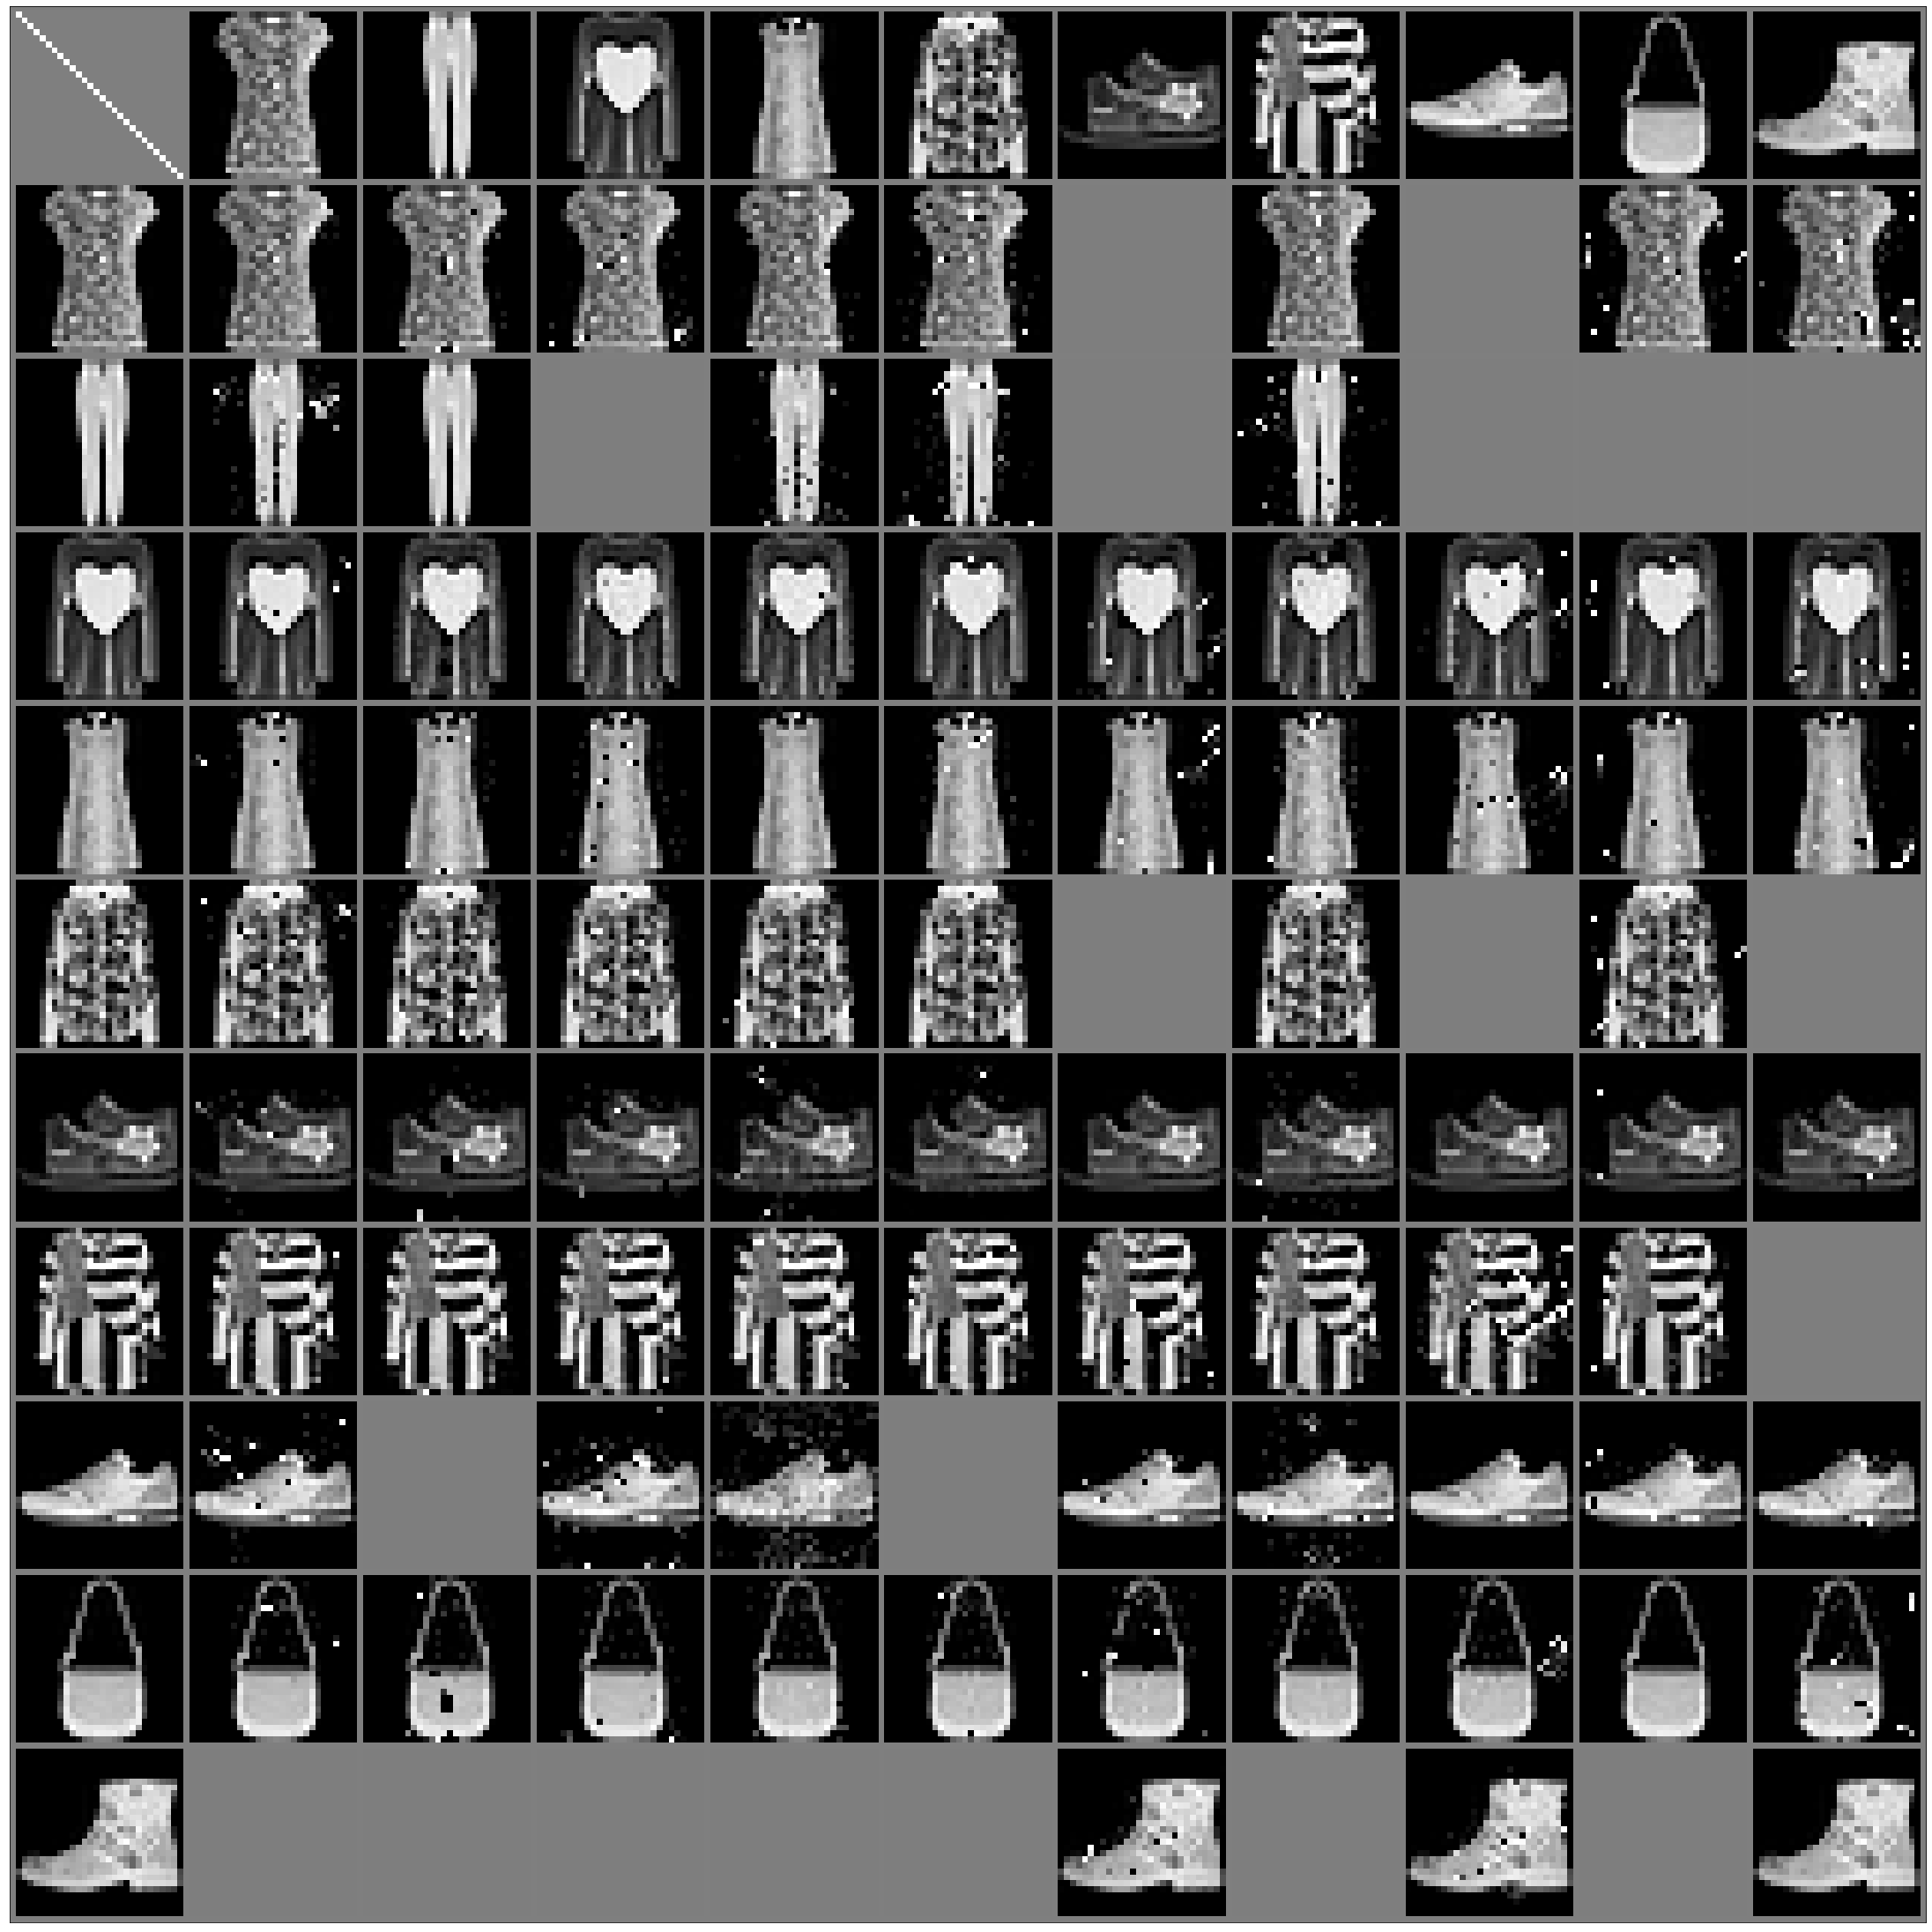

time: 1.04 s (started: 2022-04-02 22:50:03 +05:30)


In [14]:
plt.figure(figsize=(44, 40))
plt.gca().set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.imshow(np.asarray(F.to_pil_image(img)))
plt.savefig(f'{ROOT}_cf.eps', bbox_inches='tight')
plt.show()